I want to compare the results of Kraskov MI and the neural estimation one, using different values of k for Kraskov. Specifically, if the actual value of MI is very small, you are not able to estimate it using Kraskov with large k. If you decrease k, you are able to estimate it.

In [1]:
import pandas as pd
import numpy as np
from minepy import MINE
import minepy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import mutual_info_regression
from neural_estimation import MINE
# from plot_functions import compute_density, density_scatterplot

from tqdm import tqdm

In [2]:
import warnings; warnings.simplefilter('ignore')

# Try now with a bivariate Gaussian, for which the mutual information is known:

$ I(x;y) = - { 1 \over 2 } \ln (1 - \rho^2) $


In [3]:
def bivariate_gaussian(rho, size):
    mean = [0,0]
    cov_matrix = [[1, rho], [rho, 1]]
    res = np.random.multivariate_normal(mean, cov_matrix, size)
    x, y = res[:, 0], res[:, 1]
    return x.reshape(-1, 1), y.reshape(-1, 1)

def MI_bivariate_gaussian(rho):
    return -0.5*np.log(1-rho**2)

In [4]:
rho = 0.5

In [5]:
x, y = bivariate_gaussian(rho, 100)

Text(0,0.5,'y')

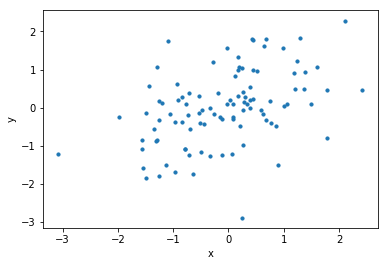

In [6]:
plt.scatter(x, y, s=10)
plt.xlabel("x")
plt.ylabel("y")

In [7]:
MI_bivariate_gaussian(rho)

0.14384103622589045

Comparison of the results for different values of k

In [8]:
k_values = [1,2,3,4,5]
rho_values = np.linspace(0, 1, 100)
MI_kraskov = np.zeros((len(k_values), len(rho_values)))

In [9]:
for i, k in enumerate(k_values):
    for j, rho in enumerate(rho_values):
        x, y = bivariate_gaussian(rho, 100)
        MI_kraskov[i, j] = mutual_info_regression(x, y, n_neighbors=k)

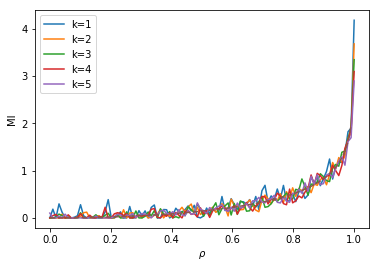

In [10]:
for i in range(len(k_values)):
    plt.plot(rho_values, MI_kraskov[i], label="k="+str(k_values[i]))

plt.plot(rho_values, MI_bivariate_gaussian(rho_values), "--")
plt.xlabel(r"$\rho$")
plt.ylabel("MI")
plt.legend()

## MINE for different epochs

In [11]:
epochs_values = [200, 400, 600, 800, 1000]
rho_values = np.linspace(0, 1, 5)[0:-1] # exlude rho=1 because you get infinite MI
MI_neural = np.zeros((len(epochs_values), len(rho_values), 2))

In [12]:
for i, epoch in enumerate(epochs_values):
    for j, rho in enumerate(rho_values):
        x, y = bivariate_gaussian(rho, 100)
        MI_neural[i, j] = MINE(x, y, n_epoch=epoch, use_tqdm=False)

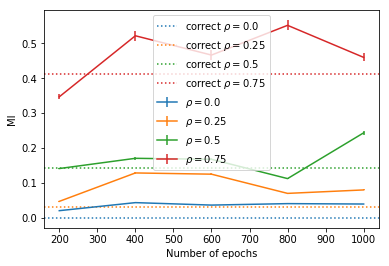

In [13]:
for i in range(len(rho_values)):
    im = plt.errorbar(epochs_values, MI_neural[:,i,0], yerr=MI_neural[:,i,1] , label=r"$\rho=$"+str(rho_values[i]))
    plt.axhline(MI_bivariate_gaussian(rho_values[i]), label = "correct "+r"$\rho=$"+str(rho_values[i]), ls='dotted', color=im[0].get_color())

plt.xlabel("Number of epochs")
plt.ylabel("MI")    
plt.legend()

# Nice plots:
## Training curve for neural estimator
I draw a bivariate Gaussian with correlation 0.9 and apply neural algorithm. Take 200 points, as it is the same number of samples as the WHO dataset

In [14]:
rho = 0.9
n_epoch = 400
exact_MI = MI_bivariate_gaussian(rho)
x, y = bivariate_gaussian(rho, 200)

In [15]:
neural_MI, var_neural_MI, neural_MI_plot = MINE(x, y, n_epoch=n_epoch, return_loss_plot=True, optimizer="Adam")

100%|██████████| 400/400 [00:00<00:00, 645.53it/s]


In [16]:
var_neural_MI

0.01124495037454103

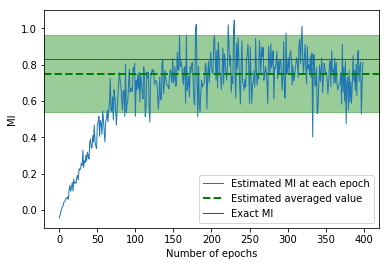

In [17]:
fig, ax = plt.subplots()
ax.plot(neural_MI_plot, lw=1, label = "Estimated MI at each epoch")
ax.axhline(y=neural_MI, color="green", ls="dashed", lw=2, label="Estimated averaged value")
ax.fill_between(np.linspace(-0.05*n_epoch, n_epoch*1.05), neural_MI-2*np.sqrt(var_neural_MI), neural_MI+2*np.sqrt(var_neural_MI), alpha=0.4, color="green")
ax.axhline(y=exact_MI, color="red", ls="-", lw=1, label="Exact MI")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("MI")
ax.set_xlim((-0.05*n_epoch, n_epoch*1.05))
ax.legend()

Still, the estimated value has not to be compared with the real one but also with the results one obtains using standard Kraskov algorithm
## Relative difference for various $\rho$ between neural and Kraskov estimate
Consider a fixed `k` and `n_epochs`

In [18]:
#k_values = [1,2,3,4,5]

#rho_values = np.log10(np.linspace(1, 10, 100))  # in this way I get many points close to 1
rho_values = np.linspace(0, 1, 100)

k=3
MI_kraskov = np.zeros((len(rho_values)))

n_epoch = 400
MI_neural = np.zeros((len(rho_values), 2))

In [19]:
#for i, k in enumerate(k_values):
for j, rho in tqdm(enumerate(rho_values)):
    x, y = bivariate_gaussian(rho, 200)
    MI_kraskov[j] = mutual_info_regression(x, y, n_neighbors=k)
    MI_neural[j] = MINE(x, y, n_epoch=n_epoch, use_tqdm=False)

100it [00:51,  1.97it/s]


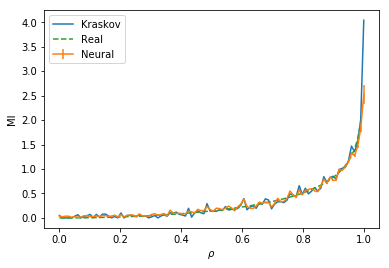

In [20]:
#for i in range(len(k_values)):
plt.plot(rho_values, MI_kraskov, label="Kraskov")
im = plt.errorbar(rho_values, MI_neural[:,0], yerr=MI_neural[:,1] , label="Neural")
plt.plot(rho_values, MI_bivariate_gaussian(rho_values), "--", label="Real")
plt.xlabel(r"$\rho$")
plt.ylabel("MI")
plt.legend()